# Spec2Vec - spectra networking
The aim of Spec2Vec is to represent each spectrum by an abstract, low-dimensional (typically 200-500 dimensional) vector which is able to capture the underlying molecular relationships between spectra.

One of the important envisioned use-cases for the Spec2Vec based spectra similarity measure, is **molecular networking**. Here we aim at clustering all spectra by building networks from nodes (=spectra) and their most prominent edges/connections (=most similar pairs of spectra).

## Notebook outline
1. Importing folders and packages
2. Import and filter MS-MS data from MGF file
3. Load model and find most similar spectra
4. Create network from cosine scores

In [1]:
import os
import sys
import gensim
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

ROOT = os.path.dirname(os.getcwd())

sys.path.insert(0, ROOT)

In [2]:
from custom_functions.spectra_functions import get_data_folder_path

path = get_data_folder_path()

/Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data


## 1. Import MoNA file

In [3]:
from matchms.importing import load_from_msp

spectrums_file = os.path.join(path, "MoNA-export-GC-MS.msp")
spectrums = [s for s in load_from_msp(spectrums_file)]

print("Number of spectra:", len(spectrums))

Number of spectra: 14847


In [4]:
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks

def post_process_s2v(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    if s is None:
        return None
    s_remove_low_peaks = select_by_relative_intensity(s, intensity_from=0.01, intensity_to=1.0)
    if len(s_remove_low_peaks.peaks) >= 10:
        s = s_remove_low_peaks
    return s

# apply post processing steps to the data
spectrums_postprocessed = [post_process_s2v(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums_postprocessed = [s for s in spectrums_postprocessed if s is not None]

In [5]:
len(spectrums_postprocessed)

14847

## 2. Load similarity matrix

In [6]:
# load already calculated scores
filename = os.path.join(path,'similarities_filter01_spec2vec_2_it1_size300.npy')
matrix_similarities_spec2vec = np.load(filename)


In [7]:
# Create numpy arrays to store top similarities for each spectrum
def get_top_hits(matrix_similarities, top_n):
    """get top_n highest scores (and indices) for every entry."""
    similars_idx = np.zeros((matrix_similarities.shape[0], top_n), dtype=int)
    similars_scores = np.zeros((matrix_similarities.shape[0], top_n))
    for i in range(matrix_similarities_spec2vec.shape[0]):
        similars_idx[i,:] = matrix_similarities[i,:].argsort()[-top_n:][::-1]
        similars_scores[i,:] = matrix_similarities[i, similars_idx[i,:]]
    return similars_idx, similars_scores

top_n = 25
spec2vec_similars_idx, spec2vec_similars = get_top_hits(matrix_similarities_spec2vec, top_n)

In [8]:
spec2vec_similars_idx[0]

array([    0,  5731,  6294, 11199, 13888,  1221,  5171, 13107, 14192,
        5170, 14194, 13078, 12641, 14193,  7654, 13173, 13174,  2922,
       12039,  4829,  3985,  9153, 12966,  5203, 10171])

In [9]:
spec2vec_similars[0]

array([1.        , 0.45961645, 0.3987923 , 0.39233435, 0.3770418 ,
       0.36022438, 0.35925586, 0.35529549, 0.34457652, 0.33962811,
       0.33920523, 0.33873347, 0.33825228, 0.33535782, 0.33258526,
       0.32980995, 0.32794844, 0.32678076, 0.32651487, 0.32564414,
       0.32142877, 0.31789762, 0.31580434, 0.3147525 , 0.31319267])

## Import reference matrix of all-vs-all molecular similarity values

In [10]:
filename = os.path.join(path, "gcms_similarities_filter05_morgan3_2048_dice.npy")
matrix_similarities_ref = np.load(filename)

In [11]:
np.any(np.isnan(matrix_similarities_ref))

False

In [12]:
nan_idx = np.argwhere(np.isnan(matrix_similarities_ref[:,1]))
nan_idx

array([], shape=(0, 1), dtype=int64)

#### Replace NaNs by 0

In [13]:
matrix_similarities_ref[np.isnan(matrix_similarities_ref)] = 0

In [14]:
def histogram_scores(scores, n_bins):
    """ Create histogram and plot it.
    """
    bins_lst = np.linspace(0, 1, n_bins+1) 
    plt.style.use('default') #('ggplot')
    plt.figure(figsize=(8,7))
    
    hist, bin_edges = np.histogram(scores, bins_lst)
    
    bar_width = 0.8 * 1/n_bins
    plt.bar(bin_edges[:-1], 100*hist/np.sum(hist), width = bar_width, color='none', edgecolor='gray', hatch="///", lw=2., zorder = 0)
    plt.bar(bin_edges[:-1], 100*hist/np.sum(hist), width = bar_width, edgecolor='black', linewidth=3, color='none',alpha=1)
    
    maxbar = np.max(100*hist/np.sum(hist))
    plt.yticks(10*np.arange(np.ceil(maxbar/10)), ["{}".format(10*x) for x in np.arange(np.ceil(maxbar/10))], fontsize=12)
    
    bar_labels = ['{:03.1f} - {:03.1f}'.format(bins_lst[i], bins_lst[i+1]) for i in range(n_bins)]
    plt.xticks(bins_lst[:-1], bar_labels, fontsize=12, rotation='vertical')
    plt.xlabel('molecular similarity (Tanimoto)', fontsize=16)
    plt.ylabel('fraction of all scores [%]', fontsize=16)
        
    return hist, bin_edges

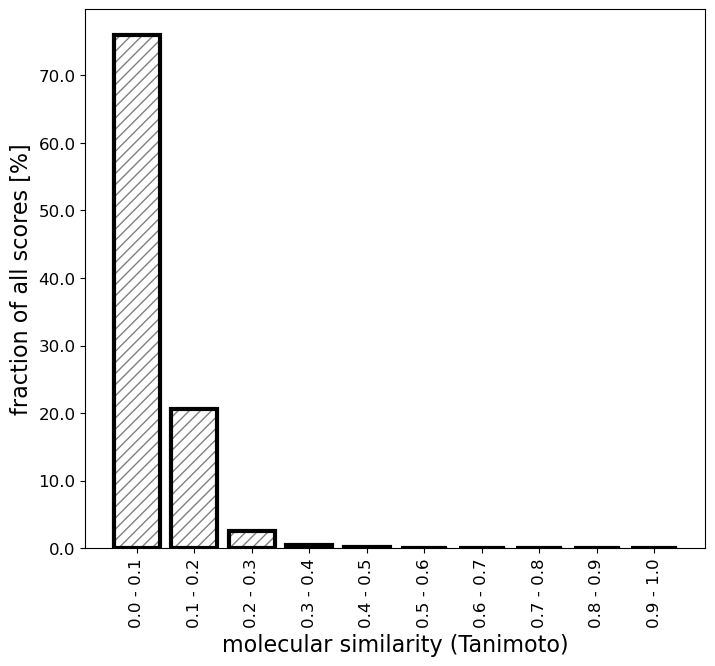

In [15]:
hist, bin_edges = histogram_scores(matrix_similarities_ref, n_bins=10)
# plt.savefig("histogram_structural_similarities.pdf", bbox_inches='tight')

In [16]:
hist/np.sum(hist)

array([7.60218034e-01, 2.05570666e-01, 2.60247579e-02, 5.05403506e-03,
       1.69108953e-03, 7.50697762e-04, 2.34460304e-04, 9.02133468e-05,
       3.74050913e-05, 3.28640170e-04])

## Create and trim the network
This will require further libraries.

    pip install networkx==2.3
    pip install python-louvain
    
    
### Import network functions

In [17]:
import custom_functions.networking as net
from custom_functions.networking import plot_clustering_performance, plots_cluster_evaluations
import networkx as nx

## 3. Create network from cosine scores
### Import all-vs-all matrix of cosine scores.

In [18]:
filename = os.path.join(path,'similarities_filt05_cosine_tol05_mzp0_intp033.npy')
matrix_similarities_cosine = np.load(filename)

filename = os.path.join(path,'similarities_filt05_cosine_tol05_mzp0_intp033_matches.npy')
matrix_matches_cosine = np.load(filename)

## Cosine score networking (basic setting)
### tol = 0.005, min_match = 1

In [63]:
top_n = 25
cos_similars_idx, cos_similars = get_top_hits(matrix_similarities_cosine, top_n)


In [64]:
MSnets_cos = []
DATA_cos = []
DATA_cos_louvain = []
thresholds = [0.6, 0.7, 0.8, 0.9, 0.95]

# Create network for different cutoff thresholds:
for thres in thresholds:
    MSnets_cos.append(net.create_network(cos_similars_idx,
                                            cos_similars,
                                            max_links = 10,
                                            cutoff = thres,
                                            link_method = 'single'))
    
   
for network in MSnets_cos:
    cluster_data = net.evaluate_clusters(network, matrix_similarities_ref)
    
    _, cluster_data_louvain = net.evaluate_clusters_louvain(network, matrix_similarities_ref, resolution = 1.0)
    
    DATA_cos.append(cluster_data)
    DATA_cos_louvain.append(cluster_data_louvain)

/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in

(-1.0, 6.8)

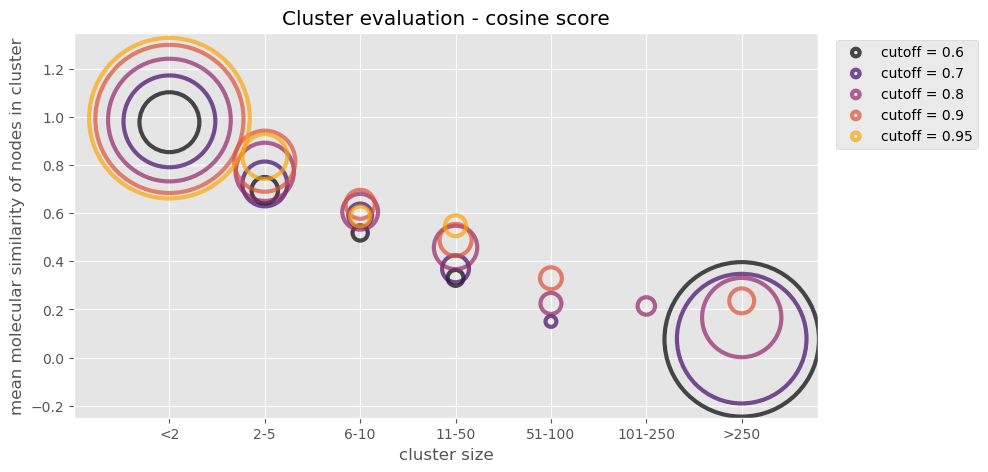

In [65]:
total_num_nodes = len(spectrums)

size_bins = [1,5,10,50,100,250, len(spectrums)]
labels_cos = ['cutoff = {}'.format(x) for x in thresholds]

plots_cluster_evaluations(DATA_cos,
                          matrix_similarities_ref,
                          total_num_nodes,
                          size_bins,
                          labels_cos,
                          title = 'Cluster evaluation - cosine score',
                          filename = 'cos_min_match1_cluster_evaluation.pdf')
plt.ylim([-0.25, 1.35])
plt.xlim([-1, 6.8])

/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in

(-1.0, 6.8)

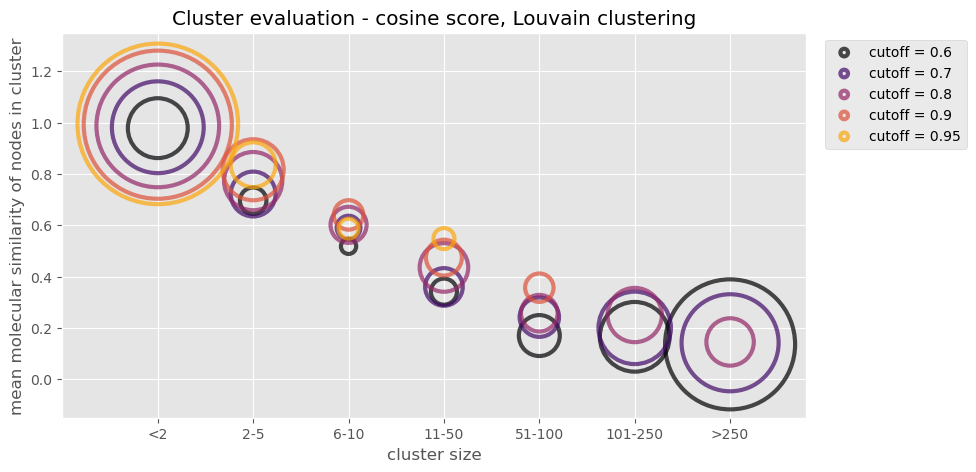

In [66]:
size_bins = [1,5,10,50,100,250, len(spectrums)]
labels_cos = ['cutoff = {}'.format(x) for x in thresholds]

plots_cluster_evaluations(DATA_cos_louvain,
                          matrix_similarities_ref,
                          total_num_nodes,
                          size_bins,
                          labels_cos,
                          title = 'Cluster evaluation - cosine score, Louvain clustering',
                          filename = 'cos_min_match1_louvain_cluster_evaluation.pdf')
plt.ylim([-0.15,1.35])
plt.xlim([-1, 6.8])

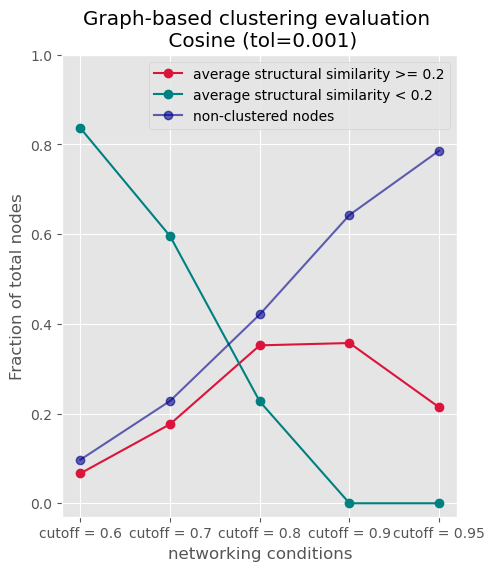

In [67]:
title = 'Graph-based clustering evaluation \n Cosine (tol=0.001)'
plot_clustering_performance(DATA_cos,
                            labels_cos,
                            thres_well = 0.2,
                            thres_poor = 0.2,
                            title = title,
                            filename = 'cos_min_match10_cluster_performance_thres05.pdf',
                            size_xy = (7,6))

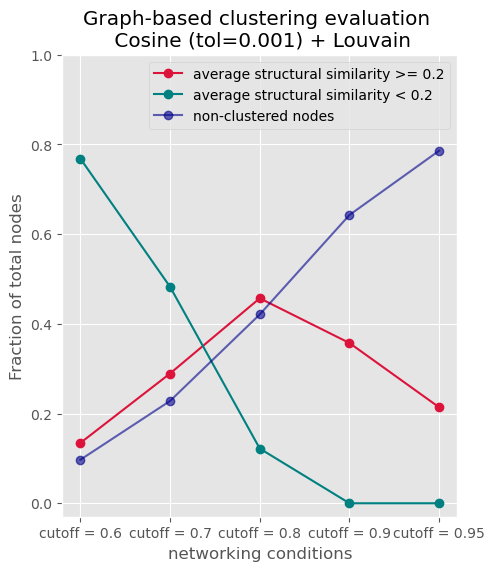

In [68]:
title = 'Graph-based clustering evaluation \n Cosine (tol=0.001) + Louvain'
plot_clustering_performance(DATA_cos_louvain,
                            labels_cos,
                            thres_well = 0.2,
                            thres_poor = 0.2,
                            title = title,
                            filename = 'cos_min_match1_louvain_cluster_performance_thres05.pdf',
                            size_xy = (7,6))

## Cosine score networking (more optimal setting)
### tol = 0.005, min_match = 10

In [25]:
top_n = 10

# Take cosine scores and set scores to 0 for <10 matches
matrix_similarities_cosine10 = matrix_similarities_cosine.copy()
matrix_similarities_cosine10[matrix_matches_cosine < 10] = 0

cos_similars_idx, cos_similars = get_top_hits(matrix_similarities_cosine10, top_n)


### Create networks for different cutoffs

In [26]:
MSnets_cos = []
DATA_cos = []
DATA_cos_louvain = []
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

for thres in thresholds:
    MSnets_cos.append(net.create_network(cos_similars_idx,
                                         cos_similars,
                                         max_links = 10,
                                         cutoff = thres,
                                         link_method = 'single'))
    
for network in MSnets_cos:
    cluster_data = net.evaluate_clusters(network, matrix_similarities_ref)
    
    _, cluster_data_louvain = net.evaluate_clusters_louvain(network, matrix_similarities_ref, resolution = 1.0)
    
    DATA_cos.append(cluster_data)
    DATA_cos_louvain.append(cluster_data_louvain)

### Plot cluster sizes (for simple, unprocessed network)

/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in

(-1.0, 6.8)

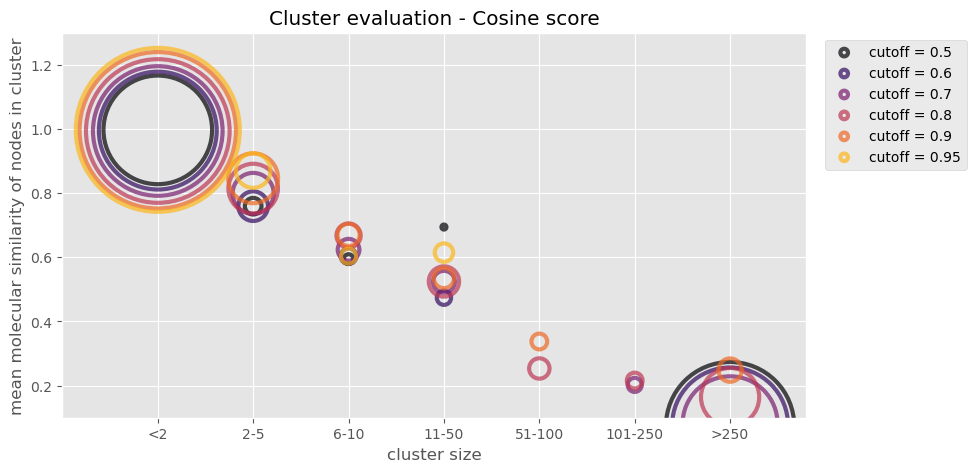

In [27]:
total_num_nodes = len(spectrums)
size_bins = [1,5,10,50,100,250, len(spectrums)]
labels_cos = ['cutoff = {}'.format(x) for x in thresholds]

plots_cluster_evaluations(DATA_cos,
                          matrix_similarities_ref,
                          total_num_nodes,
                          size_bins,
                          labels_cos,
                          title = 'Cluster evaluation - Cosine score',
                          filename = 'cos_min_match10_cluster_evaluation.pdf')

plt.ylim([0.1,1.3])
plt.xlim([-1, 6.8])

### Plot cluster sizes (using Louvain algorithm)

/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in

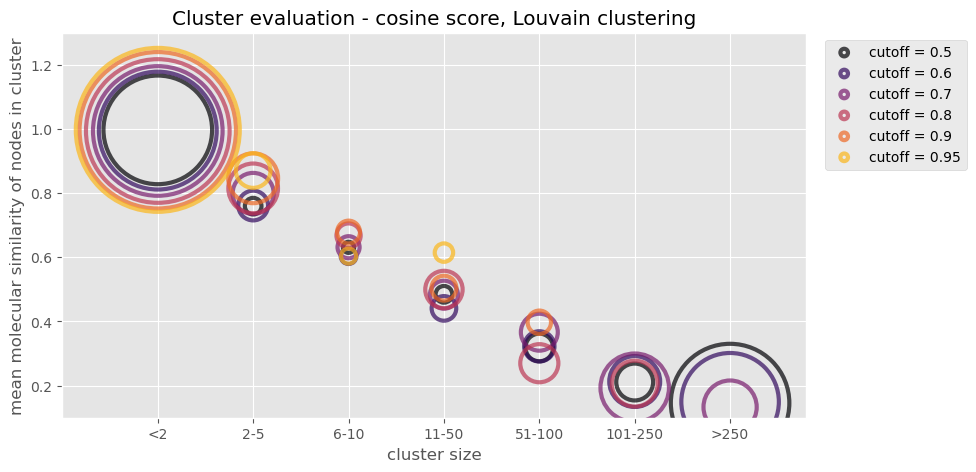

In [28]:
size_bins = [1,5,10,50,100,250, len(spectrums)]
labels_cos = ['cutoff = {}'.format(x) for x in thresholds]

plots_cluster_evaluations(DATA_cos_louvain,
                          matrix_similarities_ref,
                          total_num_nodes,
                          size_bins,
                          labels_cos,
                          title = 'Cluster evaluation - cosine score, Louvain clustering',
                          filename = 'cos_min_match10_louvain_cluster_evaluation.pdf')

plt.ylim([0.1,1.3])
plt.xlim([-1, 6.8])
plt.savefig('cos_min_match10_louvain_cluster_evaluation.pdf')

### Evalute quality of clusters
This is here done by classifying clusters with a average molecular similarity score <0.4 as poor. And clusters with a a mean molecular similariy > 0.6 as well clustered.

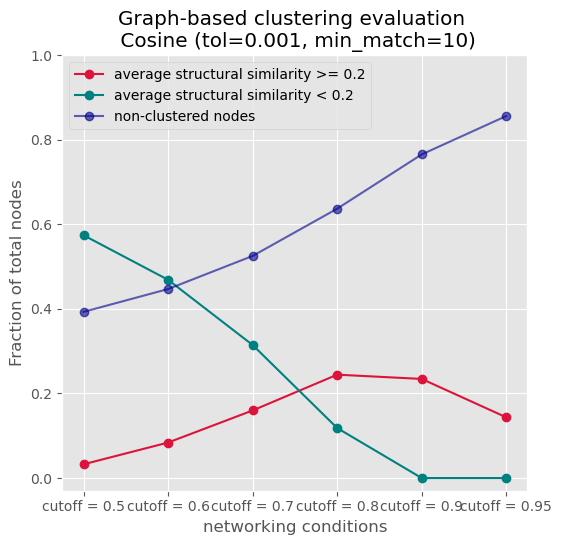

In [29]:
title = 'Graph-based clustering evaluation \n Cosine (tol=0.001, min_match=10)'
plot_clustering_performance(DATA_cos,
                            labels_cos,
                            thres_well = 0.2,
                            thres_poor = 0.2,
                            title = title,
                            filename = 'cos_min_match10_cluster_performance_thres05.pdf',
                            size_xy = (6,6))

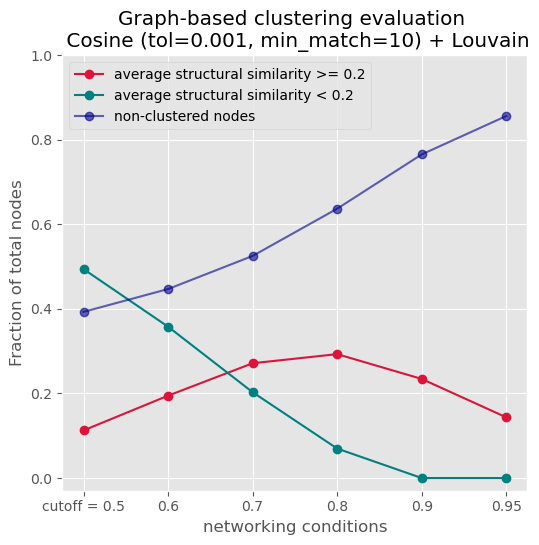

In [30]:
title = 'Graph-based clustering evaluation \n Cosine (tol=0.001, min_match=10) + Louvain'
labels_cos = ['cutoff = ' + str(thresholds[0])] + [str(x) for x in thresholds[1:]]

plot_clustering_performance(DATA_cos_louvain,
                            labels_cos,
                            thres_well = 0.2,
                            thres_poor = 0.2,
                            title = title,
                            filename = 'cos_min_match10_louvain_cluster_performance_thres05.pdf',
                            size_xy = (6,6))

## 5. Create network from Spec2Vec similarities
### Create networks for different Spev2Vec similarity cutoffs

In [31]:
MSnets_s2v = []
DATA_s2v = []
DATA_s2v_louvain = []
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

for thres in thresholds:
    MSnets_s2v.append(net.create_network(spec2vec_similars_idx,
                                         spec2vec_similars,
                                         max_links = 10,
                                         cutoff = thres,
                                         link_method = 'single'))
    
for network in MSnets_s2v:
    cluster_data = net.evaluate_clusters(network, matrix_similarities_ref)
    
    _, cluster_data_louvain = net.evaluate_clusters_louvain(network, matrix_similarities_ref, resolution = 1.0)
    
    DATA_s2v.append(cluster_data)
    DATA_s2v_louvain.append(cluster_data_louvain)

/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in

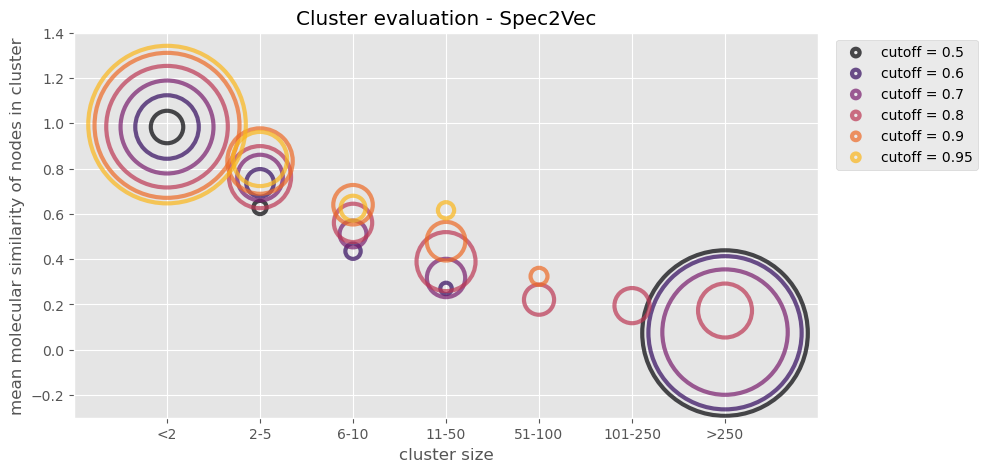

In [32]:
size_bins = [1,5,10,50,100,250, len(spectrums)]
labels_s2v = ['cutoff = ' + str(x) for x in thresholds]

plots_cluster_evaluations(DATA_s2v,
                          matrix_similarities_ref,
                          total_num_nodes,
                          size_bins,
                          labels_s2v,
                          title = 'Cluster evaluation - Spec2Vec',
                          filename = 'S2V_cluster_evaluation.pdf')

plt.ylim([-0.3,1.4])
plt.xlim([-1, 7])
plt.savefig('S2V_cluster_evaluation.pdf')

/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in

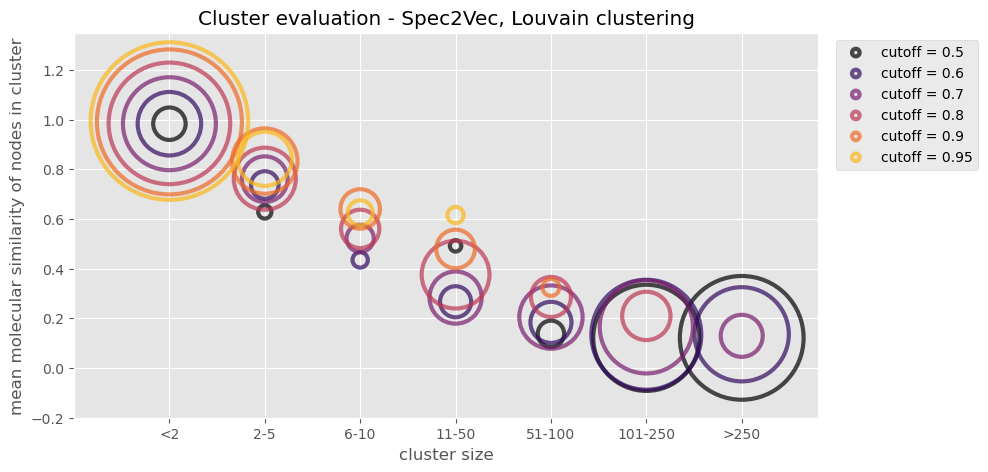

In [33]:
size_bins = [1,5,10,50,100,250, len(spectrums)]
labels_s2v = ['cutoff = ' + str(x) for x in thresholds]

plots_cluster_evaluations(DATA_s2v_louvain,
                          matrix_similarities_ref,
                          total_num_nodes,
                          size_bins,
                          labels_s2v,
                          title = 'Cluster evaluation - Spec2Vec, Louvain clustering',
                          filename = 'S2V_louvain_cluster_evaluation.pdf')

plt.ylim([-0.2, 1.35])
plt.xlim([-1, 6.8])
plt.savefig('S2V_louvain_cluster_evaluation.pdf')

#### Evalute quality of clusters
This is here done by classifying clusters with a average molecular similarity score <0.4 as poor. And clusters with a a mean molecular similariy > 0.6 as well clustered.

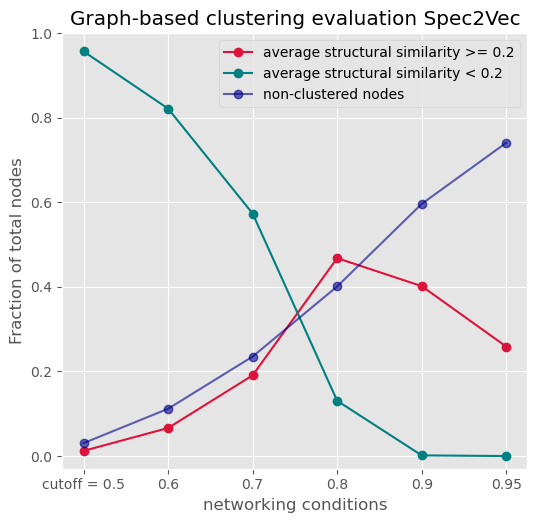

In [34]:
title = 'Graph-based clustering evaluation Spec2Vec'
labels_s2v = ['cutoff = ' + str(thresholds[0])] + [str(x) for x in thresholds[1:]]

plot_clustering_performance(DATA_s2v,
                            labels_s2v,
                            thres_well = 0.2,
                            thres_poor = 0.2,
                            title = title,
                            filename = 'S2V_cluster_performance_thres05.pdf',
                            size_xy = (6,6))

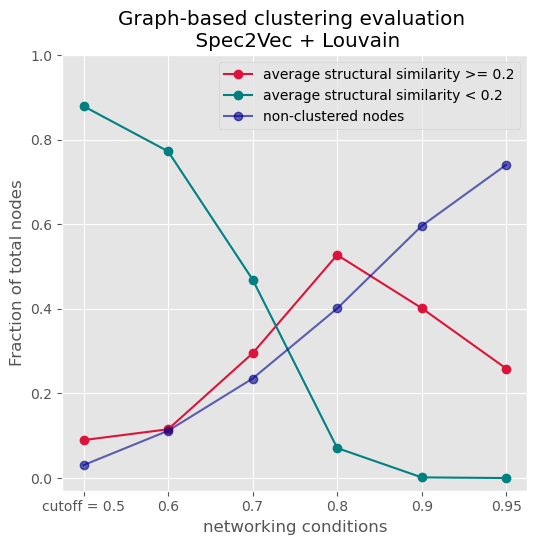

In [35]:
title = 'Graph-based clustering evaluation \n Spec2Vec + Louvain'
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
labels_s2v = ['cutoff = ' + str(thresholds[0])] + [str(x) for x in thresholds[1:]]

plot_clustering_performance(DATA_s2v_louvain,
                            labels_s2v,
                            thres_well = 0.2,
                            thres_poor = 0.2,
                            title = title,
                            filename = 'S2V_louvain_cluster_performance_thres05.pdf',
                            size_xy = (6,6))

## Try simple hybrid: Spec2Vec + Cosine

In [36]:
matrix_similarities_hybrid = (matrix_similarities_spec2vec + matrix_similarities_cosine10)/2

top_n = 25
hybrid_similars_idx, hybrid_similars = get_top_hits(matrix_similarities_hybrid, top_n)

In [37]:
MSnets_hybrid = []
DATA_hybrid = []
DATA_hybrid_louvain = []
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

for thres in thresholds:
    MSnets_hybrid.append(net.create_network(hybrid_similars_idx,
                                         hybrid_similars,
                                         max_links = 10,
                                         cutoff = thres,
                                         link_method = 'single'))
    
for network in MSnets_hybrid:
    cluster_data = net.evaluate_clusters(network, matrix_similarities_ref)
    
    _, cluster_data_louvain = net.evaluate_clusters_louvain(network, matrix_similarities_ref, resolution = 1.0)
    
    DATA_hybrid.append(cluster_data)
    DATA_hybrid_louvain.append(cluster_data_louvain)

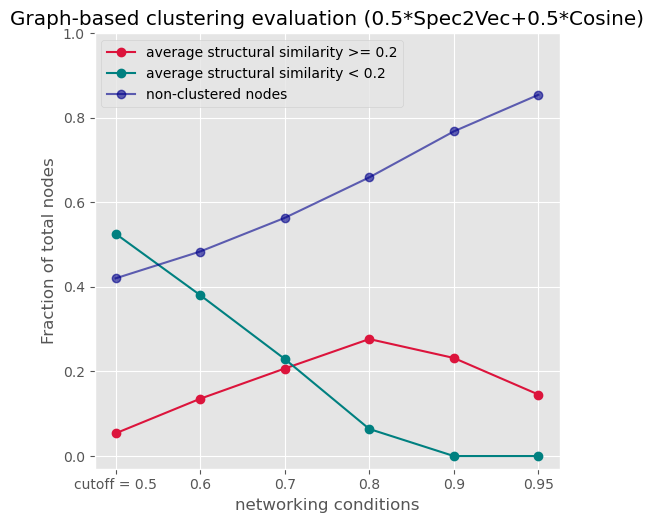

In [38]:
title = 'Graph-based clustering evaluation (0.5*Spec2Vec+0.5*Cosine)'
labels_hybrid = ['cutoff = ' + str(thresholds[0])] + [str(x) for x in thresholds[1:]]

plot_clustering_performance(DATA_hybrid,
                            labels_hybrid,
                            thres_well = 0.2,
                            thres_poor = 0.2,
                            title = title,
                            filename = 'hybrid_cluster_performance_thres05.pdf',
                            size_xy = (6,6))

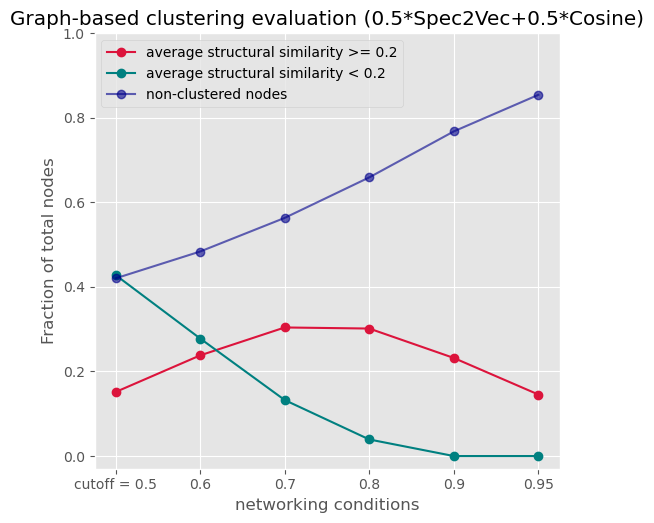

In [39]:
title = 'Graph-based clustering evaluation (0.5*Spec2Vec+0.5*Cosine)'
labels_hybrid = ['cutoff = ' + str(thresholds[0])] + [str(x) for x in thresholds[1:]]

plot_clustering_performance(DATA_hybrid_louvain,
                            labels_hybrid,
                            thres_well = 0.2,
                            thres_poor = 0.2,
                            title = title,
                            filename = 'hybrid_louvain_cluster_performance_thres05.pdf',
                            size_xy = (6,6))

## Direct comparison Cosine <-> spec2vec

/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


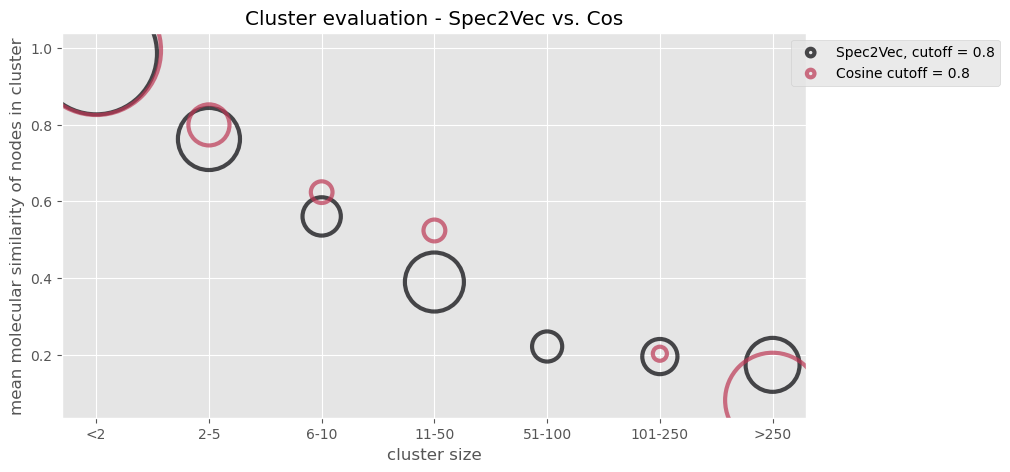

In [40]:
labels_compare = ['Spec2Vec, cutoff = 0.8','Cosine cutoff = 0.8']

plots_cluster_evaluations([DATA_s2v[3], DATA_cos[2]],
                              matrix_similarities_ref, # Tanimoto Similarities
                              total_num_nodes,
                              size_bins,
                              labels_compare,
                              title = 'Cluster evaluation - Spec2Vec vs. Cos',
                              filename = 'S2V_cos_comparison_cluster_evaluation.pdf')

## Spec2Vec dilatation

In [41]:
from custom_functions.networking import dilate_cluster

In [42]:
MSnet = net.create_network(spec2vec_similars_idx,
                           spec2vec_similars,
                           max_links = 10,
                           cutoff = 0.9,
                           link_method = 'single')

MSnet_dil, links_added = dilate_cluster(MSnet.copy(),
                           spec2vec_similars_idx,
                           spec2vec_similars,
                           max_cluster_size = 200,   
                           min_cluster_size = 10,
                           max_per_node = 1,
                           max_per_cluster = None,
                           min_weight = 0.85)

MSnet_dil2, links_added = dilate_cluster(MSnet_dil.copy(),
                           spec2vec_similars_idx,
                           spec2vec_similars,
                           max_cluster_size = 90,   
                           min_cluster_size = 10,
                           max_per_cluster = None,
                           min_weight = 0.8)

MSnet_dil3, links_added = dilate_cluster(MSnet_dil2.copy(),
                           spec2vec_similars_idx,
                           spec2vec_similars,
                           max_cluster_size = 90,   
                           min_cluster_size = 10,
                           max_per_cluster = None,
                           min_weight = 0.8)

MSnet_dil4, links_added = dilate_cluster(MSnet_dil3.copy(),
                           spec2vec_similars_idx,
                           spec2vec_similars,
                           max_cluster_size = 90,   
                           min_cluster_size = 10,
                           max_per_cluster = None,
                           min_weight = 0.8)

MSnet_dil5, links_added = dilate_cluster(MSnet_dil4.copy(),
                           spec2vec_similars_idx,
                           spec2vec_similars,
                           max_cluster_size = 20,   
                           min_cluster_size = 4,
                           max_per_cluster = None,
                           min_weight = 0.7)

In [43]:
DATA_dilation = []
DATA_dilation_louvain = []

for network in [MSnet, MSnet_dil, MSnet_dil2, MSnet_dil3, MSnet_dil4, MSnet_dil5]:
    cluster_data = net.evaluate_clusters(network,
                                     matrix_similarities_ref)
    
    _, cluster_data_louvain = net.evaluate_clusters_louvain(network,
                                                     matrix_similarities_ref,
                                                     resolution = 1.0)
    
    DATA_dilation.append(cluster_data)
    DATA_dilation_louvain.append(cluster_data_louvain)

/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in

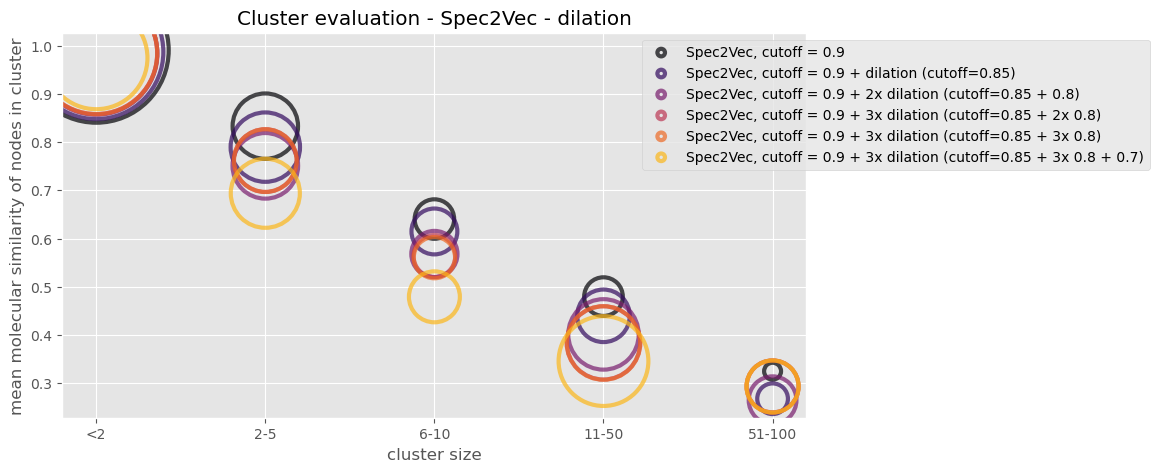

In [44]:
size_bins = [1,5,10,50,100,250, len(spectrums)]
labels_dilation = ['Spec2Vec, cutoff = 0.9',
                  'Spec2Vec, cutoff = 0.9 + dilation (cutoff=0.85)',
                 'Spec2Vec, cutoff = 0.9 + 2x dilation (cutoff=0.85 + 0.8)',
                 'Spec2Vec, cutoff = 0.9 + 3x dilation (cutoff=0.85 + 2x 0.8)',
                 'Spec2Vec, cutoff = 0.9 + 3x dilation (cutoff=0.85 + 3x 0.8)',
                 'Spec2Vec, cutoff = 0.9 + 3x dilation (cutoff=0.85 + 3x 0.8 + 0.7)']

plots_cluster_evaluations(DATA_dilation,
                              matrix_similarities_ref,
                              total_num_nodes,
                              size_bins,
                              labels_dilation,
                              title = 'Cluster evaluation - Spec2Vec - dilation',
                              filename = 'S2V_dilation_cluster_evaluation.pdf')

/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in

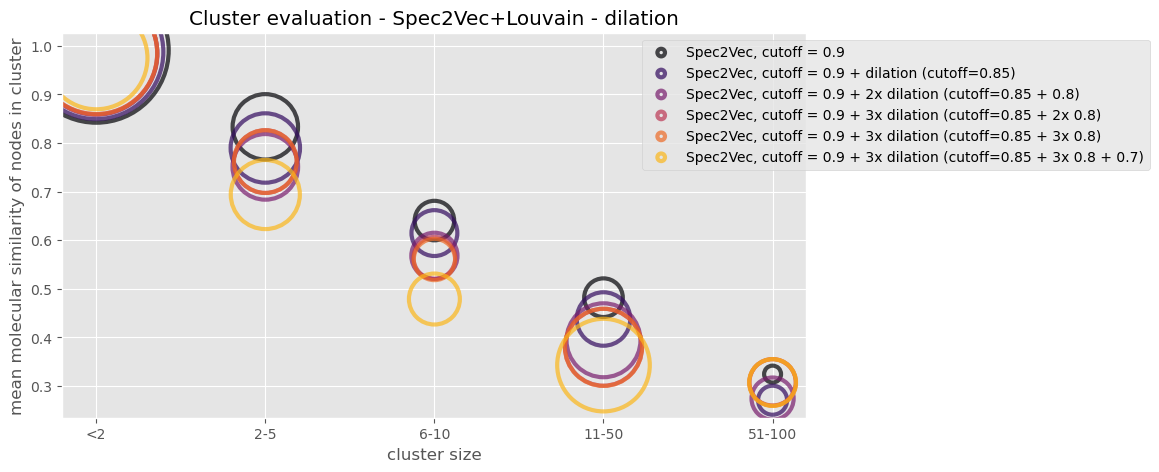

In [45]:
labels_dilation = ['Spec2Vec, cutoff = 0.9',
                  'Spec2Vec, cutoff = 0.9 + dilation (cutoff=0.85)',
                 'Spec2Vec, cutoff = 0.9 + 2x dilation (cutoff=0.85 + 0.8)',
                 'Spec2Vec, cutoff = 0.9 + 3x dilation (cutoff=0.85 + 2x 0.8)',
                 'Spec2Vec, cutoff = 0.9 + 3x dilation (cutoff=0.85 + 3x 0.8)',
                 'Spec2Vec, cutoff = 0.9 + 3x dilation (cutoff=0.85 + 3x 0.8 + 0.7)']

plots_cluster_evaluations(DATA_dilation_louvain,
                              matrix_similarities_ref,
                              total_num_nodes,
                              size_bins,
                              labels_dilation,
                              title = 'Cluster evaluation - Spec2Vec+Louvain - dilation',
                              filename = 'S2V_louvain_dilation_cluster_evaluation.pdf')

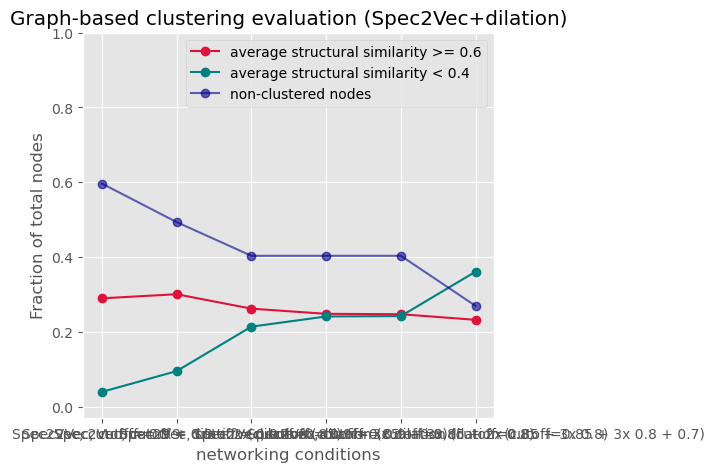

In [46]:
title = 'Graph-based clustering evaluation (Spec2Vec+dilation)'

plot_clustering_performance(DATA_dilation,
                            labels_dilation,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title,
                            filename = 'S2V_dilation_cluster_performance.pdf')

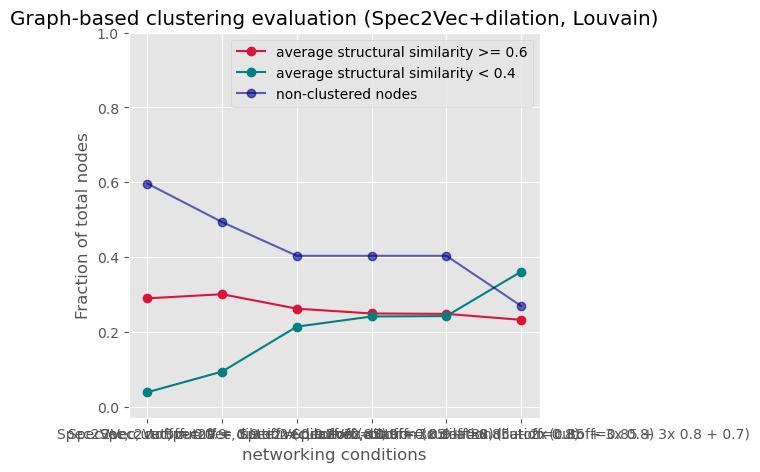

In [47]:
title = 'Graph-based clustering evaluation (Spec2Vec+dilation, Louvain)'

plot_clustering_performance(DATA_dilation_louvain,
                            labels_dilation,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title,
                            filename = 'S2V_dilation_louvain_cluster_performance.pdf')

## Dilatation Cosine

In [48]:
MSnet = net.create_network(cos_similars_idx,
                           cos_similars,
                           max_links = 10,
                           cutoff = 0.9,
                           link_method = 'single')

MSnet_dil, links_added = dilate_cluster(MSnet.copy(),
                           cos_similars_idx,
                           cos_similars,
                           max_cluster_size = 200,   
                           min_cluster_size = 10,
                           max_per_node = 1,
                           max_per_cluster = None,
                           min_weight = 0.85)

MSnet_dil2, links_added = dilate_cluster(MSnet_dil.copy(),
                           cos_similars_idx,
                           cos_similars,
                           max_cluster_size = 90,   
                           min_cluster_size = 10,
                           max_per_cluster = None,
                           min_weight = 0.8)

MSnet_dil3, links_added = dilate_cluster(MSnet_dil2.copy(),
                           cos_similars_idx,
                           cos_similars,
                           max_cluster_size = 90,   
                           min_cluster_size = 10,
                           max_per_cluster = None,
                           min_weight = 0.75)

MSnet_dil4, links_added = dilate_cluster(MSnet_dil3.copy(),
                           cos_similars_idx,
                           cos_similars,
                           max_cluster_size = 90,   
                           min_cluster_size = 10,
                           max_per_cluster = None,
                           min_weight = 0.7)

MSnet_dil5, links_added = dilate_cluster(MSnet_dil4.copy(),
                           cos_similars_idx,
                           cos_similars,
                           max_cluster_size = 20,   
                           min_cluster_size = 4,
                           max_per_cluster = None,
                           min_weight = 0.65)

In [49]:
DATA_dilation = []
DATA_dilation_louvain = []

for network in [MSnet, MSnet_dil, MSnet_dil2, MSnet_dil3, MSnet_dil4, MSnet_dil5]:
    cluster_data = net.evaluate_clusters(network,
                                     matrix_similarities_ref)
    
    _, cluster_data_louvain = net.evaluate_clusters_louvain(network,
                                                     matrix_similarities_ref,
                                                     resolution = 1.0)
    
    DATA_dilation.append(cluster_data)
    DATA_dilation_louvain.append(cluster_data_louvain)

/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in

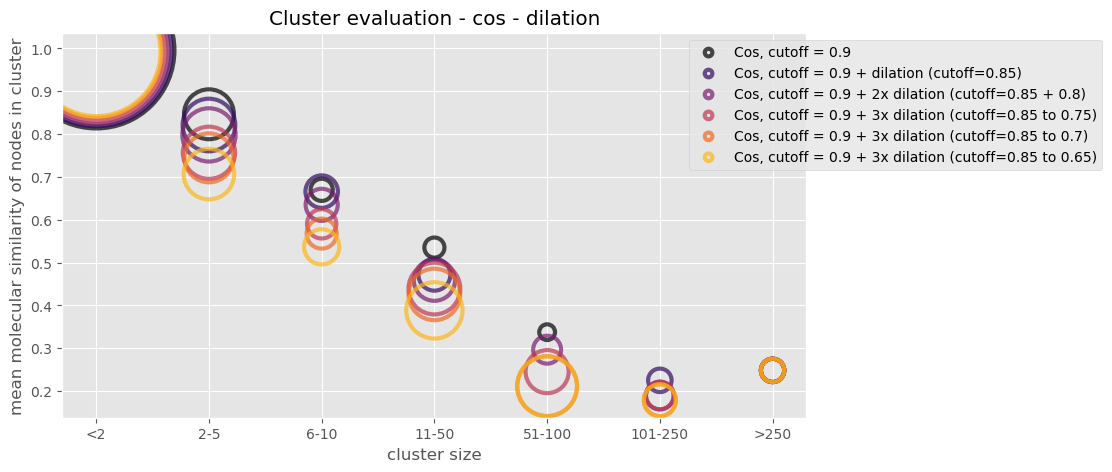

In [50]:
size_bins = [1,5,10,50,100,250, len(spectrums)]
labels_dilation = ['Cos, cutoff = 0.9',
                   'Cos, cutoff = 0.9 + dilation (cutoff=0.85)',
                   'Cos, cutoff = 0.9 + 2x dilation (cutoff=0.85 + 0.8)',
                   'Cos, cutoff = 0.9 + 3x dilation (cutoff=0.85 to 0.75)',
                   'Cos, cutoff = 0.9 + 3x dilation (cutoff=0.85 to 0.7)',
                   'Cos, cutoff = 0.9 + 3x dilation (cutoff=0.85 to 0.65)']

plots_cluster_evaluations(DATA_dilation,
                          matrix_similarities_ref,
                          total_num_nodes,
                          size_bins,
                          labels_dilation,
                          title = 'Cluster evaluation - cos - dilation',
                          filename = 'cos_dilation_cluster_evaluation.pdf')

/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in

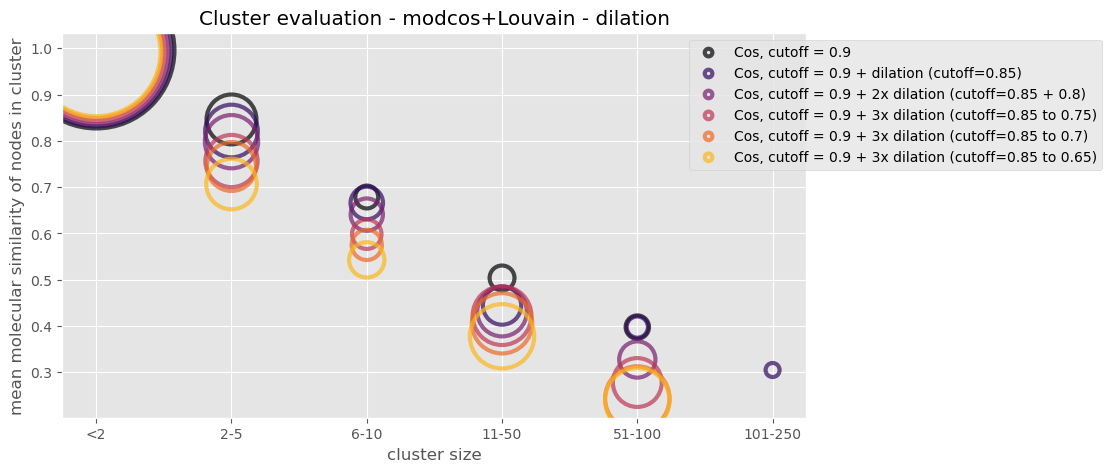

In [51]:
size_bins = [1,5,10,50,100,250, len(spectrums)]
labels_dilation = ['Cos, cutoff = 0.9',
                   'Cos, cutoff = 0.9 + dilation (cutoff=0.85)',
                   'Cos, cutoff = 0.9 + 2x dilation (cutoff=0.85 + 0.8)',
                   'Cos, cutoff = 0.9 + 3x dilation (cutoff=0.85 to 0.75)',
                   'Cos, cutoff = 0.9 + 3x dilation (cutoff=0.85 to 0.7)',
                   'Cos, cutoff = 0.9 + 3x dilation (cutoff=0.85 to 0.65)']

plots_cluster_evaluations(DATA_dilation_louvain,
                          matrix_similarities_ref,
                          total_num_nodes,
                          size_bins,
                          labels_dilation,
                          title = 'Cluster evaluation - modcos+Louvain - dilation',
                          filename = 'cos_louvain_dilation_cluster_evaluation.pdf')

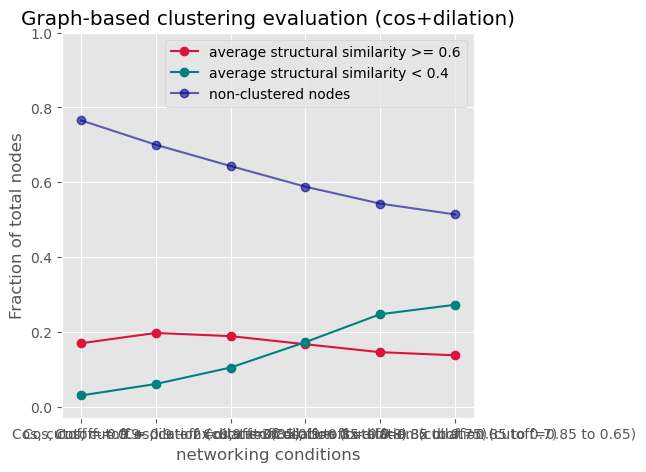

In [52]:
title = 'Graph-based clustering evaluation (cos+dilation)'

plot_clustering_performance(DATA_dilation,
                            labels_dilation,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title,
                            filename = 'cos_dilation_cluster_performance.pdf')

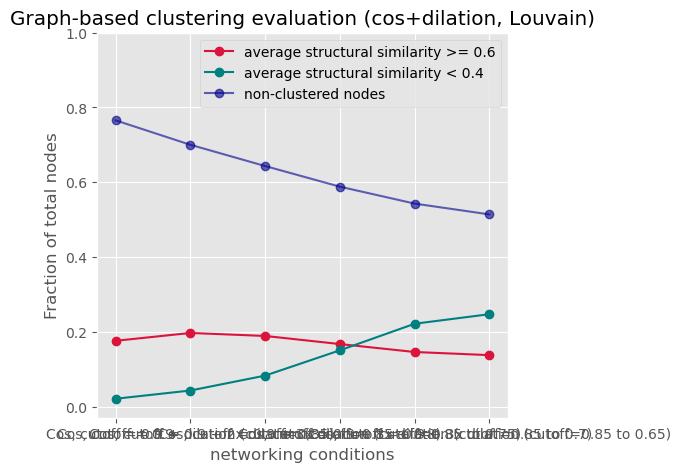

In [53]:
title = 'Graph-based clustering evaluation (cos+dilation, Louvain)'

plot_clustering_performance(DATA_dilation_louvain,
                            labels_dilation,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title,
                            filename = 'cos_dilation_louvain_cluster_performance.pdf')

## Another test based on Spec2Vec

In [54]:
MSnet = net.create_network(spec2vec_similars_idx,
                           spec2vec_similars,
                           max_links = 10,
                           cutoff = 0.9,
                           link_method = 'single')

MSnet_dil, links_added = dilate_cluster(MSnet.copy(),
                           spec2vec_similars_idx,
                           spec2vec_similars,
                           max_cluster_size = 200,   
                           min_cluster_size = 10,
                           max_per_node = 1,
                           max_per_cluster = None,
                           min_weight = 0.85)

MSnet_dil2, links_added = dilate_cluster(MSnet.copy(),
                           spec2vec_similars_idx,
                           spec2vec_similars,
                           max_cluster_size = 90,   
                           min_cluster_size = 10,
                           max_per_cluster = None,
                           min_weight = 0.75)

MSnet_dil3, links_added = dilate_cluster(MSnet_dil.copy(),
                           spec2vec_similars_idx,
                           spec2vec_similars,
                           max_cluster_size = 90,   
                           min_cluster_size = 10,
                           max_per_cluster = None,
                           min_weight = 0.85)

MSnet_dil4, links_added = dilate_cluster(MSnet_dil.copy(),
                           spec2vec_similars_idx,
                           spec2vec_similars,
                           max_cluster_size = 90,   
                           min_cluster_size = 10,
                           max_per_cluster = None,
                           min_weight = 0.8)

MSnet_dil5, links_added = dilate_cluster(MSnet_dil.copy(),
                           spec2vec_similars_idx,
                           spec2vec_similars,
                           max_cluster_size = 20,   
                           min_cluster_size = 4,
                           max_per_cluster = None,
                           min_weight = 0.7)

In [55]:
DATA_dilation = []
DATA_dilation_louvain = []

for network in [MSnet, MSnet_dil, MSnet_dil2, MSnet_dil3, MSnet_dil4, MSnet_dil5]:
    cluster_data = net.evaluate_clusters(network,
                                         matrix_similarities_ref)
    
    _, cluster_data_louvain = net.evaluate_clusters_louvain(network,
                                                     matrix_similarities_ref,
                                                     resolution = 1.0)
    
    DATA_dilation.append(cluster_data)
    DATA_dilation_louvain.append(cluster_data_louvain)

/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in

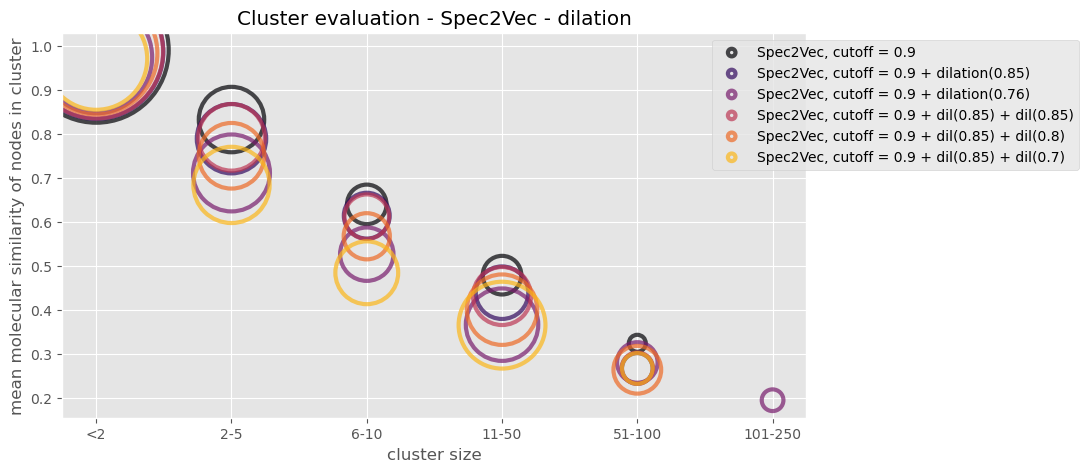

In [56]:
size_bins = [1,5,10,50,100,250, len(spectrums)]
labels_dilation = ['Spec2Vec, cutoff = 0.9',
                   'Spec2Vec, cutoff = 0.9 + dilation(0.85)',
                   'Spec2Vec, cutoff = 0.9 + dilation(0.76)',
                   'Spec2Vec, cutoff = 0.9 + dil(0.85) + dil(0.85)',
                   'Spec2Vec, cutoff = 0.9 + dil(0.85) + dil(0.8)',
                   'Spec2Vec, cutoff = 0.9 + dil(0.85) + dil(0.7)']

plots_cluster_evaluations(DATA_dilation,
                          matrix_similarities_ref,
                          total_num_nodes,
                          size_bins,
                          labels_dilation,
                          title = 'Cluster evaluation - Spec2Vec - dilation',
                          filename = 'S2V_dilation_cluster_evaluation2.pdf')

/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in

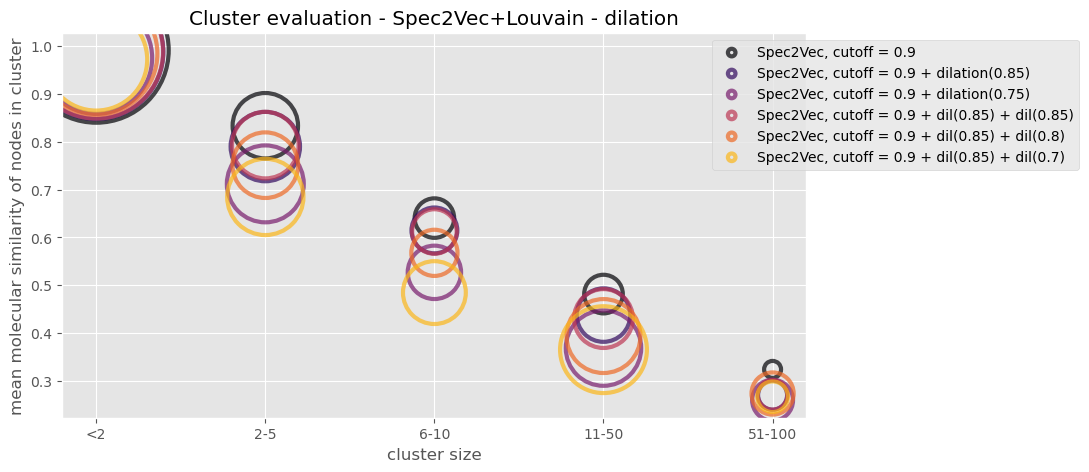

In [57]:
size_bins = [1,5,10,50,100,250, len(spectrums)]
labels_dilation = ['Spec2Vec, cutoff = 0.9',
                   'Spec2Vec, cutoff = 0.9 + dilation(0.85)',
                   'Spec2Vec, cutoff = 0.9 + dilation(0.75)',
                   'Spec2Vec, cutoff = 0.9 + dil(0.85) + dil(0.85)',
                   'Spec2Vec, cutoff = 0.9 + dil(0.85) + dil(0.8)',
                   'Spec2Vec, cutoff = 0.9 + dil(0.85) + dil(0.7)']

plots_cluster_evaluations(DATA_dilation_louvain,
                          matrix_similarities_ref,
                          total_num_nodes,
                          size_bins,
                          labels_dilation,
                          title = 'Cluster evaluation - Spec2Vec+Louvain - dilation',
                          filename = 'S2V_louvain_dilation_cluster_evaluation2.pdf')

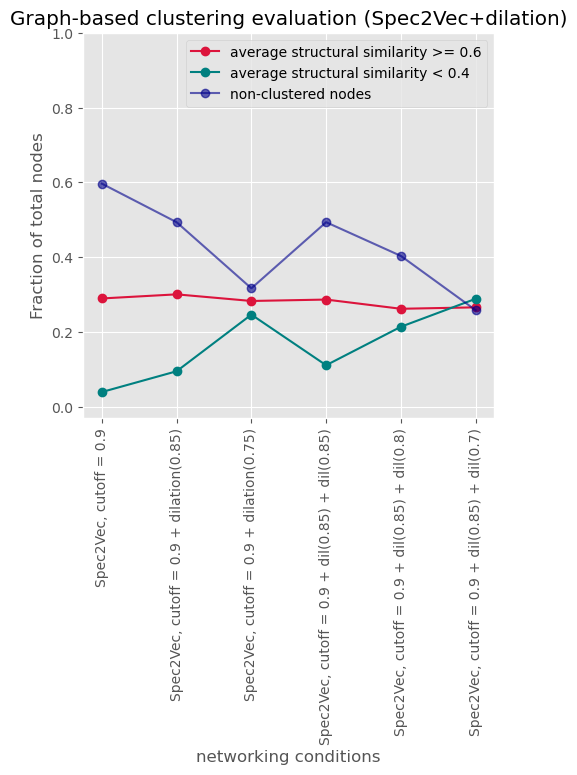

In [58]:
title = 'Graph-based clustering evaluation (Spec2Vec+dilation)'

plot_clustering_performance(DATA_dilation,
                            labels_dilation,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title,
                            filename = 'S2V_dilation_cluster_performance2.pdf')
plt.xticks(labels_dilation, rotation='vertical')
plt.savefig('S2V_dilation_cluster_performance2.pdf', dpi=600)

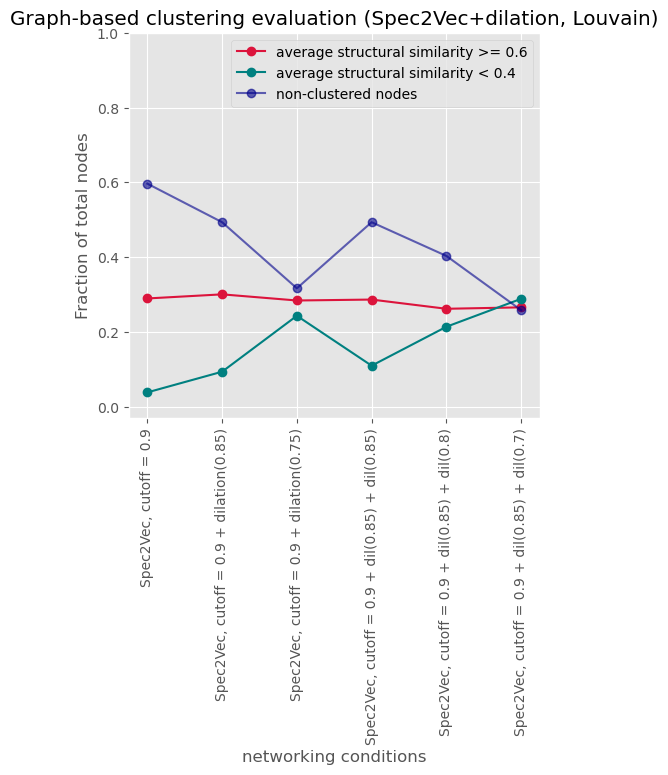

In [59]:
title = 'Graph-based clustering evaluation (Spec2Vec+dilation, Louvain)'

plot_clustering_performance(DATA_dilation_louvain,
                            labels_dilation,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title,
                            filename = 'S2V_dilation_louvain_cluster_performance2.pdf')
plt.xticks(labels_dilation, rotation='vertical')
plt.savefig('S2V_dilation_louvain_cluster_performance2.pdf', dpi=600)

## Network

In [60]:
cm = plt.cm.get_cmap('gray')

def plot_cluster(G):
    if len(G.nodes) > 1:
        edges = [(u, v) for (u, v, d) in G.edges(data=True) ]
        weights = [d['weight'] for (u, v, d) in G.edges(data=True) ]
        weights = weights - 0.95*np.min(weights)
        weights = weights/np.max(weights)

        pos = nx.spring_layout(G)  # positions for all nodes
        plt.figure(figsize=(12,12))
        # nodes
        nx.draw_networkx_nodes(G, pos, node_size=100)

        # edges
        nx.draw_networkx_edges(G, pos, edgelist=edges, width=4*weights, alpha=0.5)

        # labels
        nx.draw_networkx_labels(G, pos, font_size=5, font_family='sans-serif')

        plt.axis('off')
        plt.show()

In [61]:
MSnet_dil4_2 = net.add_intra_cluster_links(MSnet_dil4.copy(),
                           matrix_similarities_ref, 
                           min_weight = 0.7)

AttributeError: module 'matplotlib.cbook' has no attribute 'iterable'

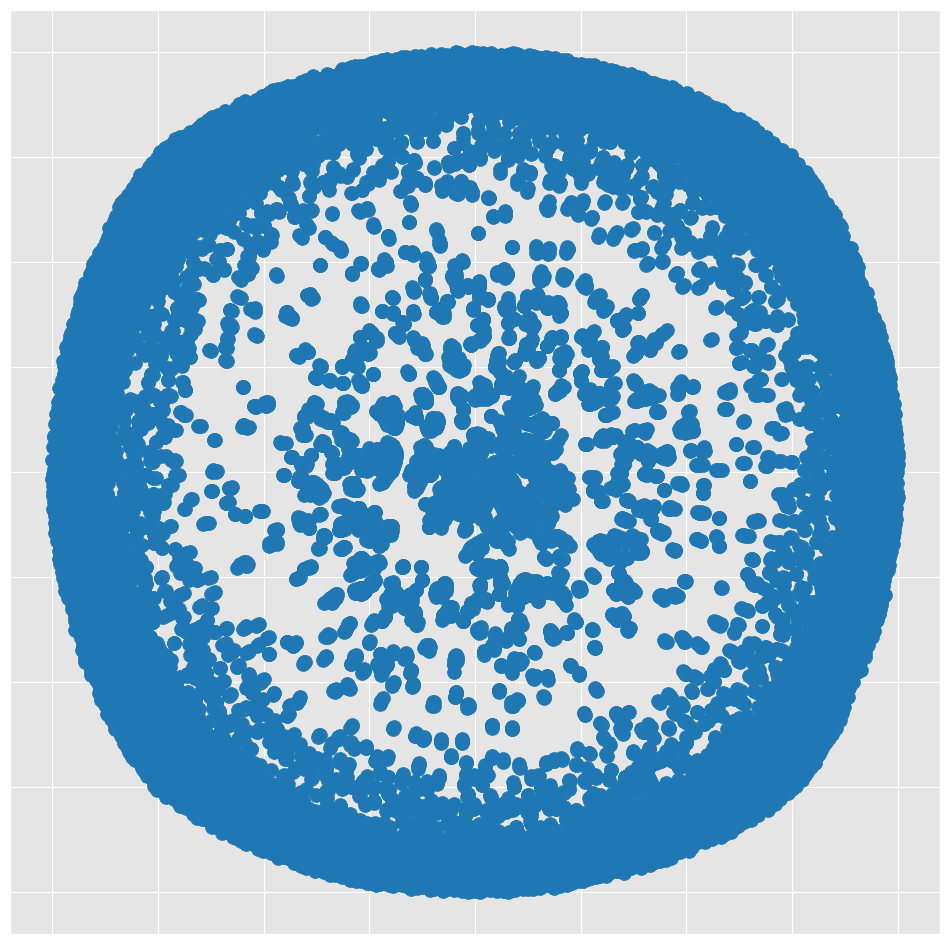

In [62]:
plot_cluster(MSnet_dil4_2)
print('density:', nx.density(MSnet_dil4_2))
print('transitivity:', nx.transitivity(MSnet_dil4_2))

In [ ]:
MSnet_dil2_added = net.add_intra_cluster_links(MSnet_dil2.copy(),
                                       matrix_similarities_ref,
                                       min_weight = 0.7)

In [ ]:
cluster_data = net.evaluate_clusters(MSnet_dil2_added,
                                     matrix_similarities_ref)

_, cluster_data_louvain = net.evaluate_clusters_louvain(MSnet_dil2_added,
                                                 matrix_similarities_ref,
                                                 resolution = 1.0)

DATA_dilation.append(cluster_data)
DATA_dilation_louvain.append(cluster_data_louvain)

In [ ]:
title = 'Graph-based clustering evaluation (Spec2Vec+dilation, Louvain)'

plot_clustering_performance(DATA_dilation_louvain,
                            labels_dilation + ['added links to dil(0.75)'],
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title,
                            filename = 'S2V_dilation_louvain_cluster_performance2.pdf')
plt.xticks(labels_dilation, rotation='vertical')
plt.savefig('S2V_dilation_louvain_cluster_performance3.pdf', dpi=600)

In [ ]:
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

for thres in thresholds:
    MSnets_s2v.append(net.create_network(spec2vec_similars_idx,
                                         spec2vec_similars,
                                         max_links = 10,
                                         cutoff = thres,
                                         link_method = 'single'))

In [ ]:
size_bins = [5,10,50,100,250, len(spectrums)]
bins = [0] + [x+1 for x in size_bins]
x_labels = ['2-5', '6-10', '11-50', '51-100', '101-250', '>250']

In [ ]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
cm = plt.get_cmap('inferno') #'jet' 
cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

fig = plt.figure(figsize=(8,4))
ax = plt.subplot(111)
for i, [num_elements, mean_edge_sim, mean_node_sim] in enumerate(plots):
    colorVal = scalarMap.to_rgba(i/(len(plots)+1))
    plt.plot(x_labels, mean_node_sim, 'o-', alpha= 0.7, lw=2, markersize=8, 
             color= colorVal, label=labels[i])
    plt.xlabel('cluster size')
    plt.ylabel('mean molecular similarity of nodes in cluster')
    
chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.8, chartBox.height])
lgnd = ax.legend(loc='upper center', bbox_to_anchor=(1.2, 1))
for i in range(len(plots)):
    lgnd.legendHandles[i]._sizes = [30]

fig = plt.figure(figsize=(8,4))
ax = plt.subplot(111)
for i, [num_elements, mean_edge_sim, mean_node_sim] in enumerate(plots):
    colorVal = scalarMap.to_rgba(i/(len(plots)+1))
    plt.plot(x_labels, num_elements, 'o-', alpha= 0.7, lw=2, markersize=8, 
             color= colorVal, label=labels[i])
    plt.xlabel('cluster size')
    plt.ylabel('number of nodes in clusters of respective size')

chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.8, chartBox.height])
lgnd = ax.legend(loc='upper center', bbox_to_anchor=(1.2, 1))
for i in range(len(plots)):
    lgnd.legendHandles[i]._sizes = [30]

In [ ]:
networks = [MSnet1, MSnet2, MSnet3, MSnet4, MSnet5]
y_max = 500
    
""" Run evaluation and series of plots.
"""
plt.style.use('ggplot')

data_collection = []
for network in networks:
    cluster_data = evaluate_clusters(network,
                                     matrix_similarities_ref)
    
    data_collection.append(cluster_data)

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
for cluster_data in data_collection:    

    cum_dist = []
    cluster_sizes_unique = cluster_data.sort_values(by=('num_nodes'))['num_nodes'].unique()
    for cluster_size in cluster_sizes_unique:
        num_elements = cluster_size * np.sum(cluster_data['num_nodes'] == cluster_size)
        cum_dist.append((cluster_size, num_elements))
    y,x = np.array(list((zip(*cum_dist))))
    y[y>y_max] = y_max
    x_cum = [np.sum(x[:(i+1)]) for i in range(len(x))]
    plt.step(x_cum, y, where='pre', label='post')
    plt.plot(x_cum, y, 'C2o', alpha=0.5)    

plt.xlabel('cumulative distribution accros total number of clusters')
plt.ylabel('cluster size')